In [128]:
import warnings
warnings.filterwarnings("ignore")  # silence warnings

import pandas as pd
from datetime import datetime,date
from causalnex.structure import StructureModel
from sklearn.preprocessing import LabelEncoder

from causalnex.structure.notears import from_pandas
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.network import BayesianNetwork

from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
import pickle


In [8]:
import sys
sys.path.append("../scripts/")
from data_cleaner import DataCleaner
cleaner = DataCleaner()

In [9]:
df  = pd.read_csv('../data/merged_df.csv')
clean_df = pd.read_csv('../data/clean_merged_df.csv')

In [10]:
clean_df.head()

,order_id,driver_lat,driver_lng,origin_lat,origin_lng,distance_diff,trip_start_time,duration_min,holiday,action_count,driver_action,fulfilled,weekend
0,392001,6.602207,3.270465,6.601042,3.276634,0.694264,2021-07-01 09:30:59,3.0,False,1,accepted,False,False
1,392005,6.549147,3.392184,6.565088,3.384441,1.959786,2021-07-01 10:53:36,34.0,False,1,accepted,True,False
2,392009,6.644829,3.289328,6.663648,3.308206,2.947683,2021-07-01 06:39:51,61.0,False,1,accepted,True,False
3,392013,6.435331,3.424317,6.430817,3.434155,1.197389,2021-07-01 08:44:09,35.0,False,1,accepted,True,False
4,392014,6.498221,3.360042,6.499156,3.358517,0.197853,2021-07-01 06:43:07,44.0,False,1,accepted,True,False


In [11]:
df["date"]=df["trip_start_time"].apply(lambda x: pd.to_datetime(x).date())
df["hour"]=df["trip_start_time"].apply(lambda x: pd.to_datetime(x).hour)
df.drop(columns="trip_start_time",inplace=True)

In [12]:
df = cleaner.find_distance(df,distance_col_name="distance_diff",trip_origin_col_names=["driver_lat","driver_lng"],trip_destination_col_names=["origin_lat","origin_lng"])


In [13]:
temp_df=df.copy()

In [43]:
convert_to_num_cols=["driver_lat","driver_lng","duration_min","origin_lat","origin_lng","hour","distance_diff"]
df = cleaner.convert_to_numbers(df,convert_to_num_cols)

convert_to_str_cols=["driver_id","driver_action","holiday"]
df = cleaner.convert_to_string(df,convert_to_str_cols)

convert_to_date_cols=["date"]
df = cleaner.convert_to_datetime(df,convert_to_date_cols)

# df[convert_to_num_cols] = df[convert_to_num_cols].apply(pd.to_numeric)


# for col in convert_to_str_cols:
#     df[col] = df[col].astype(str)

# df["date"] =  pd.to_datetime(df["date"])


In [45]:
df["fulfilled"] = (df["driver_action"] == "accepted") & (df["duration_min"] >=10)

In [46]:
df.head()

,id,order_id,driver_id,driver_action,driver_lat,driver_lng,duration_min,holiday,origin_lat,origin_lng,date,hour,distance_diff,fulfilled
0,1,392001,243828,accepted,6.602207,3.270465,3.0,False,6.601042,3.276634,2021-07-01,9,0.694264,False
1,2,392001,243588,rejected,6.592097,3.287445,3.0,False,6.601042,3.276634,2021-07-01,9,1.551694,False
2,3,392001,243830,rejected,6.596133,3.281784,3.0,False,6.601042,3.276634,2021-07-01,9,0.786777,False
3,4,392001,243539,rejected,6.596142,3.280526,3.0,False,6.601042,3.276634,2021-07-01,9,0.692054,False
4,5,392001,171653,rejected,6.609232,3.288800,3.0,False,6.601042,3.276634,2021-07-01,9,1.621848,False


In [16]:

def labe_encoder(df:pd.DataFrame,columns:list=None):
    if columns == None:
        # columns = df.select_dtypes(exclude = ['number','datetime'])
        columns = df.select_dtypes(exclude = ['number'])
    le = LabelEncoder()

    for col in columns:
        df[col] = le.fit_transform(df[col])

    return df

In [47]:
# df = cleaner.label_encoder(df)
df = labe_encoder(df)


In [51]:
driver_loc=df[["driver_lat","driver_lng"]]
request_loc=df[["origin_lat","origin_lng"]]

In [52]:
# create kmeans model/object
kmeans = KMeans(
    init="random",
    n_clusters=50,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [54]:
# do clustering
kmeans.fit(driver_loc)
# save results
driver_labels = kmeans.labels_

In [55]:
# do clustering
kmeans.fit(request_loc)
# save results
request_labels = kmeans.labels_

In [57]:
df["driver_loc"]=driver_labels
df["request_loc"]=request_labels

In [60]:
df.drop(columns=["duration_min","fulfilled","order_id","driver","id","driver_lat","driver_lng","origin_lat","origin_lng"],inplace=True)
df.rename(columns={"driver_id":"driver"},inplace=True)

In [72]:
# make a copy of dataframe
scaled_features = df.copy()

col_names = ['duration_min', 'distance_diff']
features = scaled_features[col_names]

# Use scaler of choice; here Standard scaler is used
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_features[col_names] = features

df = scaled_features.copy()

In [85]:

sm = from_pandas(df)

In [120]:
sm_enh = from_pandas(df, tabu_edges=[("distance_diff","driver_loc")],tabu_parent_nodes=["driver_action"],tabu_child_nodes=["date","hour"], w_threshold=0.7)

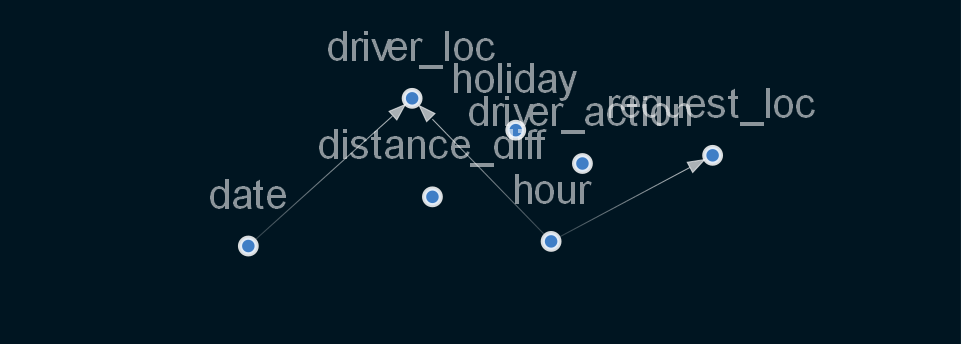

In [121]:
viz = plot_structure(
    sm_enh,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp'
)
Image(viz.draw(format='png'))

In [122]:
sm_enh.add_edge("distance_diff", "driver_action")
sm_enh.add_edge("date", "driver_action")
sm_enh.add_edge("date", "holiday")
sm_enh.add_edge("hour", "driver_action")
sm_enh.add_edge("request_loc", "distance_diff")
sm_enh.add_edge("driver_loc", "distance_diff")
sm_enh.add_edge("distance_diff", "driver_action")

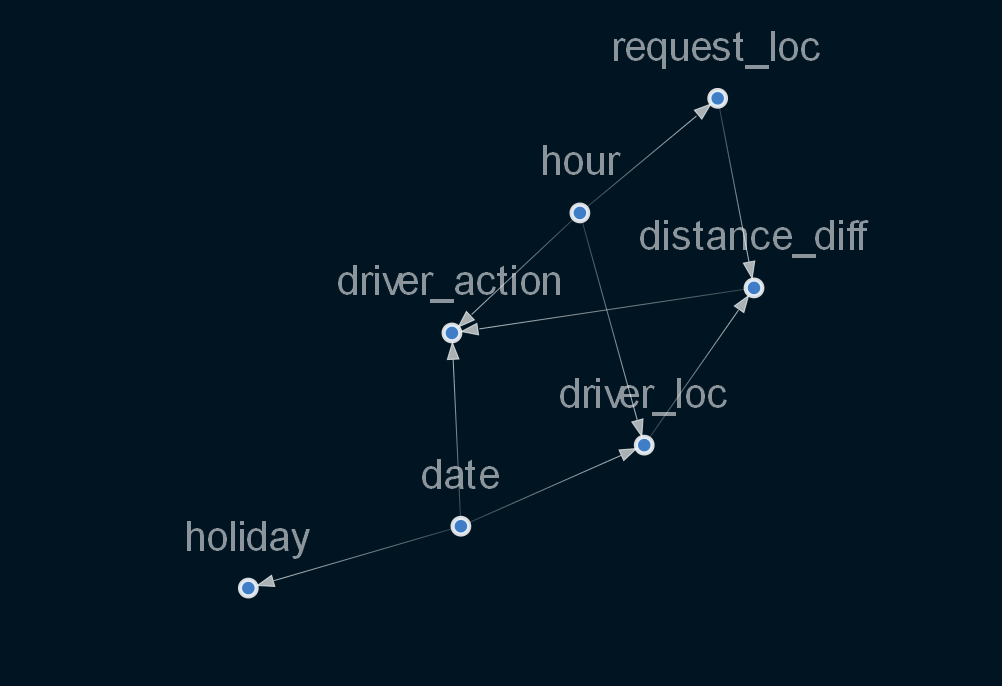

In [123]:
viz = plot_structure(
    sm_enh,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp'
)
Image(viz.draw(format='png'))

Exporting our findings

In [127]:
# with open('../models/sm.pkl', 'wb') as structural_model:
#   pickle.dump(sm, structural_model)


# import networkx as nx

# nx.drawing.nx_pydot.write_dot(sm_enh, '../doc/graph.dot')

In [150]:
cleaned_driver_loc=clean_df[["driver_lat","driver_lng"]]
cleaned_request_loc=clean_df[["origin_lat","origin_lng"]]

In [151]:
# do clustering
kmeans.fit(cleaned_request_loc)
# save results
cleaned_request_labels = kmeans.labels_

# do clustering
kmeans.fit(cleaned_driver_loc)
# save results
cleaned_driver_labels = kmeans.labels_

In [152]:
clustered_df=clean_df.copy()

clustered_df["driver_loc"]=cleaned_driver_labels
clustered_df["request_loc"]=cleaned_request_labels

In [153]:
clustered_df.drop(columns=["order_id","driver_lat","driver_lng","origin_lat","origin_lng","action_count"],inplace=True)
# clustered_df.rename(columns={"driver_id":"driver"},inplace=True)

In [154]:
clustered_df["month"]=clustered_df["trip_start_time"].apply(lambda x: pd.to_datetime(x).month)
clustered_df["day"]=clustered_df["trip_start_time"].apply(lambda x: pd.to_datetime(x).day)
clustered_df["hour"]=clustered_df["trip_start_time"].apply(lambda x: pd.to_datetime(x).hour)
clustered_df["minute"]=clustered_df["trip_start_time"].apply(lambda x: pd.to_datetime(x).minute)
clustered_df.drop(columns="trip_start_time",inplace=True)

In [158]:
clustered_df=labe_encoder(clustered_df,["holiday","driver_action","fulfilled","weekend"])

In [155]:
clustered_df.head()

,distance_diff,duration_min,holiday,driver_action,fulfilled,weekend,driver_loc,request_loc,month,day,hour,minute
0,0.694264,3.0,False,accepted,False,False,37,32,7,1,9,30
1,1.959786,34.0,False,accepted,True,False,3,12,7,1,10,53
2,2.947683,61.0,False,accepted,True,False,4,6,7,1,6,39
3,1.197389,35.0,False,accepted,True,False,6,15,7,1,8,44
4,0.197853,44.0,False,accepted,True,False,27,26,7,1,6,43


In [161]:
clustered_df.head()

,distance_diff,duration_min,holiday,driver_action,fulfilled,weekend,driver_loc,request_loc,month,day,hour,minute
0,0.694264,3.0,0,0,0,0,37,32,7,1,9,30
1,1.959786,34.0,0,0,1,0,3,12,7,1,10,53
2,2.947683,61.0,0,0,1,0,4,6,7,1,6,39
3,1.197389,35.0,0,0,1,0,6,15,7,1,8,44
4,0.197853,44.0,0,0,1,0,27,26,7,1,6,43


In [187]:
no_edges=[("fulfilled","duration_min"),("fulfilled","driver_loc"),("driver_action","driver_loc"),("driver_action","distance_diff"),("driver_action","duration_min")]
sm_enhanced = from_pandas(clustered_df,tabu_child_nodes=["month","day","hour","minute"])


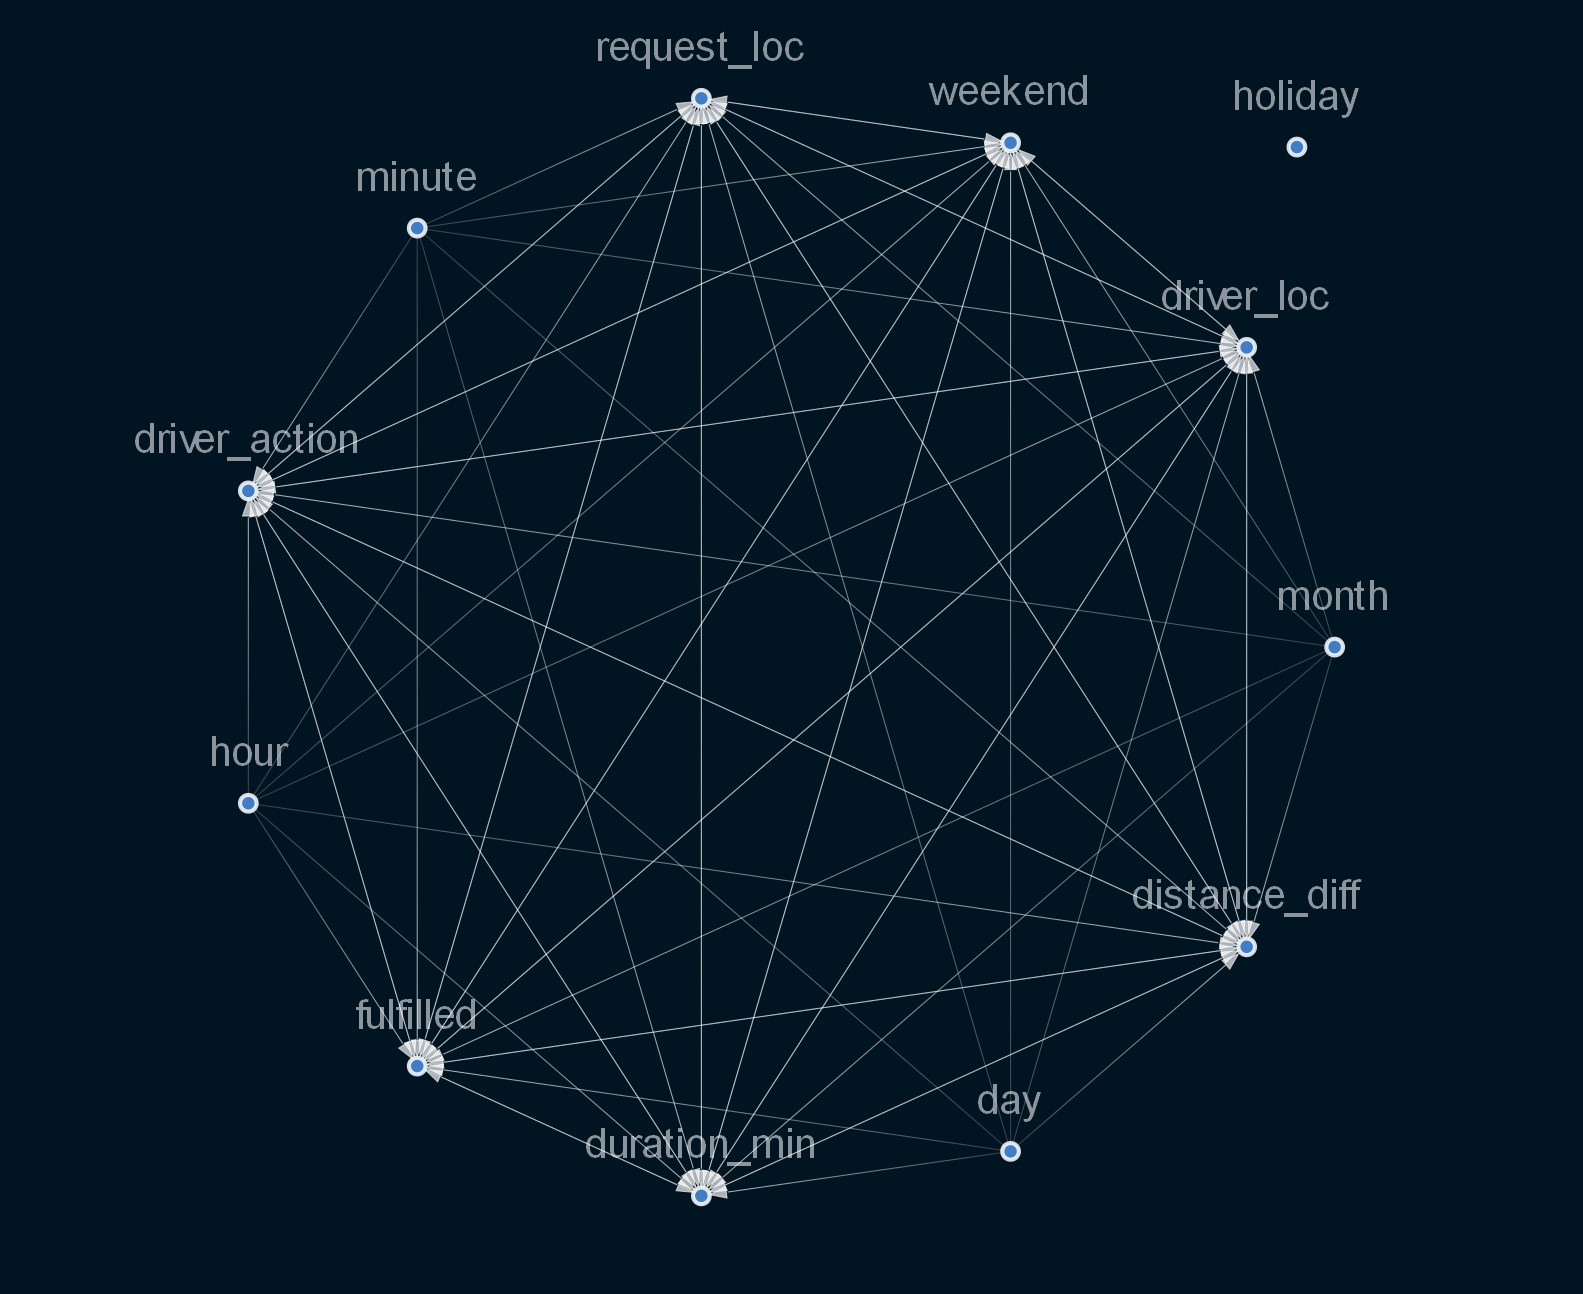

In [188]:
viz = plot_structure(
    sm_enhanced,
    graph_attributes={"scale": "0.8"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog="circo"
)
Image(viz.draw(format='png'))

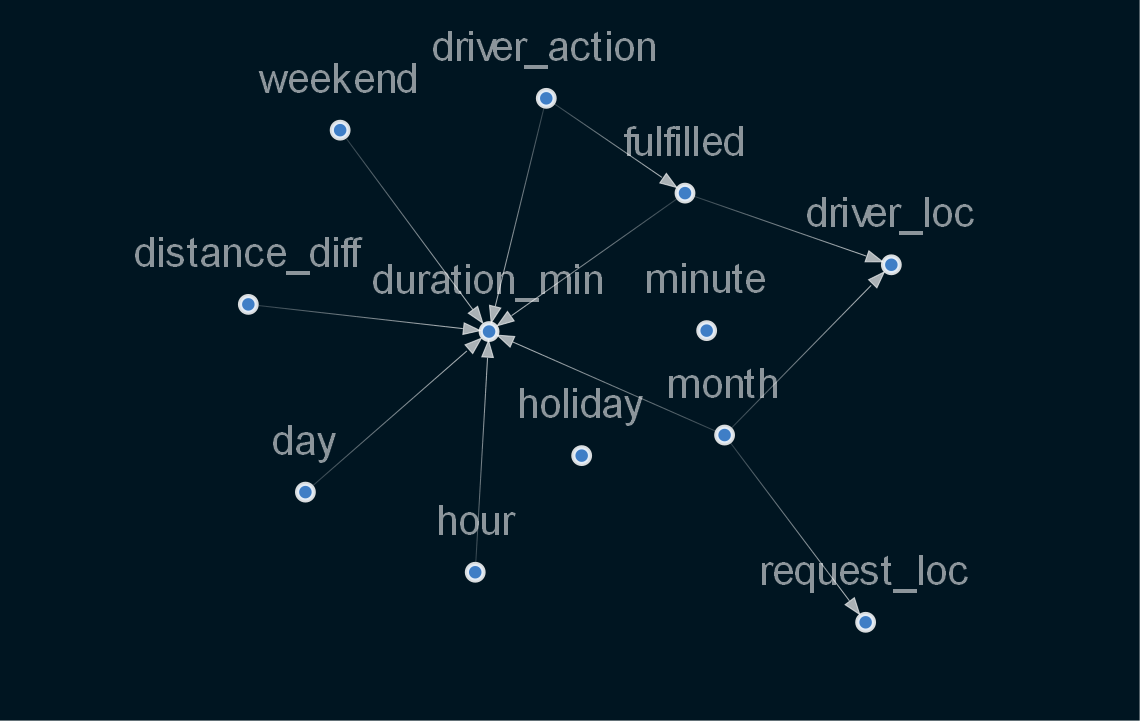

In [203]:
sm_enhanced.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm_enhanced,
    graph_attributes={"scale": "0.7","fontsize":"small"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [208]:
sm_enhanced.remove_edge("driver_action","distance_diff")
sm_enhanced.remove_edge("driver_action","driver_loc")
sm_enhanced.remove_edge("fulfilled","driver_loc")

In [204]:
sm_enhanced.add_edge("distance_diff", "driver_action")
sm_enhanced.add_edge("day", "driver_action")
sm_enhanced.add_edge("hour", "driver_action")
sm_enhanced.add_edge("request_loc", "distance_diff")
sm_enhanced.add_edge("driver_loc", "distance_diff")
sm_enhanced.add_edge("distance_diff", "driver_action")

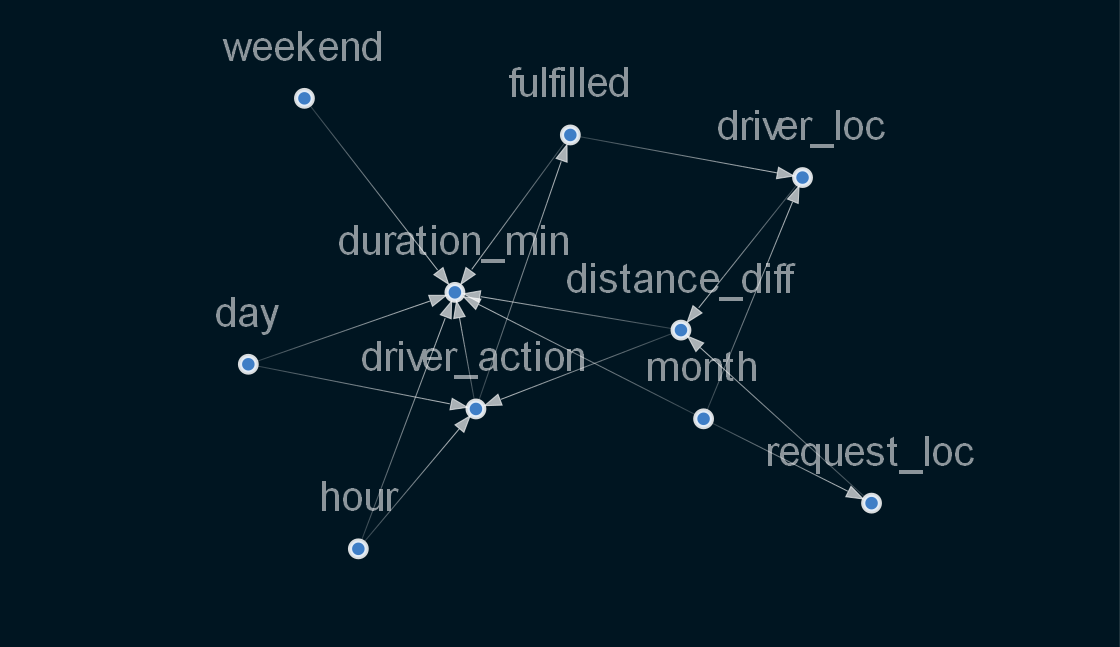

In [206]:
sm_enhanced = sm_enhanced.get_largest_subgraph()
viz = plot_structure(
    sm_enhanced,
    graph_attributes={"scale": "0.7","fontsize":"small"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [210]:
clustered_df.head()

,distance_diff,duration_min,holiday,driver_action,fulfilled,weekend,driver_loc,request_loc,month,day,hour,minute
0,0.694264,3.0,0,0,0,0,37,32,7,1,9,30
1,1.959786,34.0,0,0,1,0,3,12,7,1,10,53
2,2.947683,61.0,0,0,1,0,4,6,7,1,6,39
3,1.197389,35.0,0,0,1,0,6,15,7,1,8,44
4,0.197853,44.0,0,0,1,0,27,26,7,1,6,43


In [209]:
bn = BayesianNetwork(sm_enhanced)

In [211]:
from causalnex.discretiser import Discretiser

discretised_data = clustered_df.copy()

discretised_data["duration_min"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["duration_min"].values)
discretised_data["distance_diff"] = Discretiser(method="fixed",
                          numeric_split_points=[1]).transform(discretised_data["distance_diff"].values)
discretised_data["month"] = Discretiser(method="fixed",
                          numeric_split_points=[4,8]).transform(discretised_data["month"].values)
discretised_data["day"] = Discretiser(method="fixed",
                          numeric_split_points=[10,20]).transform(discretised_data["day"].values)
discretised_data["minute"] = Discretiser(method="fixed",
                          numeric_split_points=[30]).transform(discretised_data["minute"].values)
discretised_data["hour"] = Discretiser(method="fixed",
                          numeric_split_points=[8,16]).transform(discretised_data["hour"].values)

In [223]:
fullfilled_map = {0: "yes", 1: "no"}
holiday_map = {0: "no", 1: "yes"}
weekend_map = {0: "no", 1: "yes"}
driver_action_map = {0: "accepted", 1: "rejected"}

hour_map = {0:"early",1:"working_hour",2:"late"}
distance_map = {0:"near",1:"far"}
duration_map = {0:"short",1:"valid"}


discretised_data["fulfilled"] = discretised_data["fulfilled"].map(fullfilled_map)
discretised_data["holiday"] = discretised_data["holiday"].map(holiday_map)
discretised_data["weekend"] = discretised_data["weekend"].map(weekend_map)
discretised_data["driver_action"] = discretised_data["driver_action"].map(driver_action_map)
discretised_data["hour"] = discretised_data["hour"].map(hour_map)
discretised_data["distance_diff"] = discretised_data["distance_diff"].map(distance_map)
discretised_data["duration_min"] = discretised_data["duration_min"].map(duration_map)

In [225]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

In [226]:
bn = bn.fit_node_states(discretised_data)

In [227]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [228]:
bn.cpds["driver_action"]

day                   0                                             \
distance_diff       far                             near             
hour              early      late working_hour     early      late   
driver_action                                                        
accepted       0.996403  0.988586     0.985162  0.979798  0.964202   
rejected       0.003597  0.011414     0.014838  0.020202  0.035798   

day                            1                                    \
distance_diff                far                    near             
hour          working_hour early late working_hour early      late   
driver_action                                                        
accepted          0.958906   0.5  0.2          0.2   0.5  0.333333   
rejected          0.041094   0.5  0.8          0.8   0.5  0.666667   

day                            2                                            
distance_diff                far                    near                    
hour          working_hour early late working_hour early late working_hour  
driver_action                                                               
accepted          0.071429   0.5  0.5         0.75   0.5  0.2          0.5  
rejected          0.928571   0.5  0.5         0.25   0.5  0.8          0.5

In [229]:
discretised_data.loc[18, discretised_data.columns != 'driver_action']

distance_diff             far
duration_min            valid
holiday                    no
fulfilled                  no
weekend                    no
driver_loc                 35
request_loc                16
month                       1
day                         0
hour             working_hour
minute                      0
Name: 18, dtype: object

In [230]:
predictions = bn.predict(discretised_data, "driver_action")

In [231]:
print(f"The prediction is '{predictions.loc[18, 'driver_action_prediction']}'")

The prediction is 'accepted'


In [232]:

print(f"The ground truth is '{discretised_data.loc[18, 'driver_action']}'")

The ground truth is 'accepted'
